# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import torch
import torch.optim as optim
import zuko
from src.models.cnf import CNF
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf, train_realnvp
from src.utils.visualization import (
    plot_data_distribution,
    plot_transformation,
    plot_transformation_realnvp
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. Dataset 2D

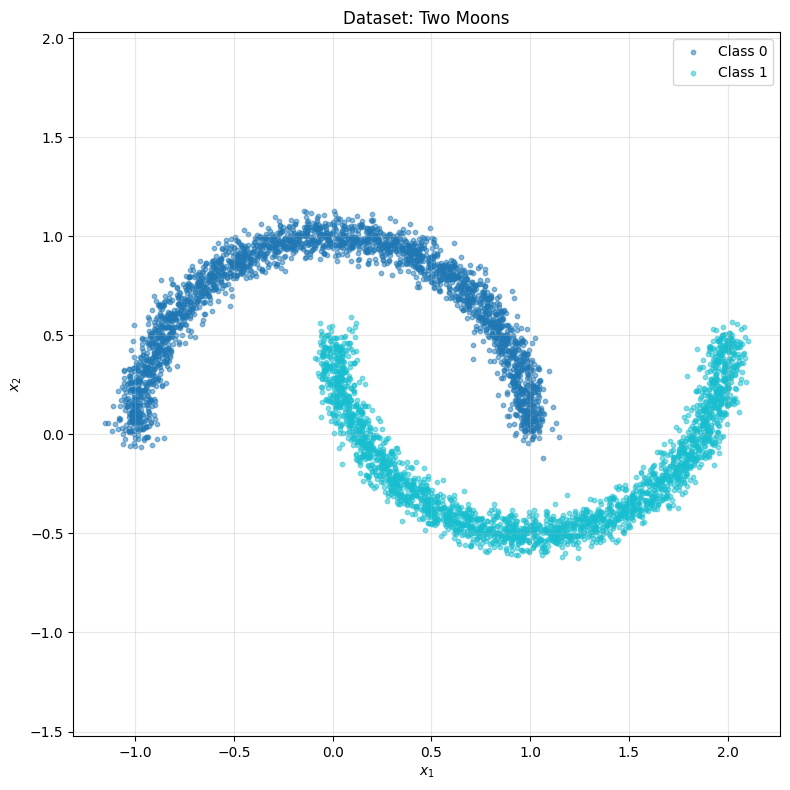

In [2]:
# Criar dataset 2D
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data_distribution(
    dataset_2d.data,
    labels=dataset_2d.labels,
    ax=ax,
    title="Dataset: Two Moons"
)
plt.tight_layout()
plt.show()


### 1.1 CNF


In [3]:
# Criar e treinar CNF
vf_2d = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d).to(device)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-3)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, device, num_epochs=5)

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

plot_transformation(
    cnf_2d,
    n_samples=1000,
    n_trajectory_points=100
)
plt.tight_layout()
plt.show()


Treinando CNF em dados 2D...


Epoch 1/5: 100%|██████████| 40/40 [00:02<00:00, 14.46it/s]


Epoch 1, Loss: 2.1983


Epoch 2/5:  22%|██▎       | 9/40 [00:00<00:02, 10.67it/s]


KeyboardInterrupt: 

### 1.2. RealNVP


Treinando RealNVP em dados 2D...


Epoch 1/50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 40/40 [00:00<00:00, 99.95it/s]


Epoch 1, Loss: 1.8346


Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 92.89it/s] 


Epoch 2, Loss: 1.5690


Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 90.77it/s]


Epoch 3, Loss: 1.3960


Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 81.26it/s]


Epoch 4, Loss: 1.2253


Epoch 5/50: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 5, Loss: 1.0870


Epoch 6/50: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 6, Loss: 1.1305


Epoch 7/50: 100%|██████████| 40/40 [00:00<00:00, 82.48it/s] 


Epoch 7, Loss: 0.9688


Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 101.35it/s]


Epoch 8, Loss: 0.9312


Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 121.47it/s]


Epoch 9, Loss: 0.8711


Epoch 10/50: 100%|██████████| 40/40 [00:00<00:00, 89.28it/s] 


Epoch 10, Loss: 0.8452


Epoch 11/50: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 11, Loss: 0.7654


Epoch 12/50: 100%|██████████| 40/40 [00:00<00:00, 109.25it/s]


Epoch 12, Loss: 0.8440


Epoch 13/50: 100%|██████████| 40/40 [00:00<00:00, 105.54it/s]


Epoch 13, Loss: 0.7484


Epoch 14/50: 100%|██████████| 40/40 [00:00<00:00, 71.20it/s]


Epoch 14, Loss: 0.8374


Epoch 15/50: 100%|██████████| 40/40 [00:00<00:00, 99.44it/s]


Epoch 15, Loss: 0.7367


Epoch 16/50: 100%|██████████| 40/40 [00:00<00:00, 112.58it/s]


Epoch 16, Loss: 0.7085


Epoch 17/50: 100%|██████████| 40/40 [00:00<00:00, 58.38it/s]


Epoch 17, Loss: 0.7994


Epoch 18/50: 100%|██████████| 40/40 [00:00<00:00, 110.20it/s]


Epoch 18, Loss: 0.6768


Epoch 19/50: 100%|██████████| 40/40 [00:00<00:00, 74.03it/s]


Epoch 19, Loss: 0.6392


Epoch 20/50: 100%|██████████| 40/40 [00:00<00:00, 82.92it/s]


Epoch 20, Loss: 0.7497


Epoch 21/50: 100%|██████████| 40/40 [00:00<00:00, 80.53it/s]


Epoch 21, Loss: 0.6833


Epoch 22/50: 100%|██████████| 40/40 [00:00<00:00, 82.06it/s]


Epoch 22, Loss: 0.6534


Epoch 23/50: 100%|██████████| 40/40 [00:00<00:00, 93.13it/s] 


Epoch 23, Loss: 0.5944


Epoch 24/50: 100%|██████████| 40/40 [00:00<00:00, 82.53it/s]


Epoch 24, Loss: 0.6047


Epoch 25/50: 100%|██████████| 40/40 [00:00<00:00, 80.20it/s]


Epoch 25, Loss: 0.5856


Epoch 26/50: 100%|██████████| 40/40 [00:00<00:00, 96.75it/s] 


Epoch 26, Loss: 0.5607


Epoch 27/50: 100%|██████████| 40/40 [00:00<00:00, 106.04it/s]


Epoch 27, Loss: 0.5913


Epoch 28/50: 100%|██████████| 40/40 [00:00<00:00, 99.69it/s] 


Epoch 28, Loss: 0.6342


Epoch 29/50: 100%|██████████| 40/40 [00:00<00:00, 151.60it/s]


Epoch 29, Loss: 0.6065


Epoch 30/50: 100%|██████████| 40/40 [00:00<00:00, 128.29it/s]


Epoch 30, Loss: 0.6600


Epoch 31/50: 100%|██████████| 40/40 [00:00<00:00, 103.99it/s]


Epoch 31, Loss: 0.5721


Epoch 32/50: 100%|██████████| 40/40 [00:00<00:00, 118.72it/s]


Epoch 32, Loss: 0.5889


Epoch 33/50: 100%|██████████| 40/40 [00:00<00:00, 150.67it/s]


Epoch 33, Loss: 0.5627


Epoch 34/50: 100%|██████████| 40/40 [00:00<00:00, 170.20it/s]


Epoch 34, Loss: 0.5439


Epoch 35/50: 100%|██████████| 40/40 [00:00<00:00, 151.22it/s]


Epoch 35, Loss: 0.5444


Epoch 36/50: 100%|██████████| 40/40 [00:00<00:00, 143.24it/s]


Epoch 36, Loss: 0.5076


Epoch 37/50: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 37, Loss: 0.5461


Epoch 38/50: 100%|██████████| 40/40 [00:00<00:00, 156.65it/s]


Epoch 38, Loss: 0.5607


Epoch 39/50: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 39, Loss: 0.5085


Epoch 40/50: 100%|██████████| 40/40 [00:00<00:00, 143.42it/s]


Epoch 40, Loss: 0.4972


Epoch 41/50: 100%|██████████| 40/40 [00:00<00:00, 153.34it/s]


Epoch 41, Loss: 0.5104


Epoch 42/50: 100%|██████████| 40/40 [00:00<00:00, 101.41it/s]


Epoch 42, Loss: 0.4802


Epoch 43/50: 100%|██████████| 40/40 [00:00<00:00, 93.24it/s] 


Epoch 43, Loss: 0.5174


Epoch 44/50: 100%|██████████| 40/40 [00:00<00:00, 127.38it/s]


Epoch 44, Loss: 0.6250


Epoch 45/50: 100%|██████████| 40/40 [00:00<00:00, 109.44it/s]


Epoch 45, Loss: 0.4901


Epoch 46/50: 100%|██████████| 40/40 [00:00<00:00, 151.87it/s]


Epoch 46, Loss: 0.5227


Epoch 47/50: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 47, Loss: 0.4863


Epoch 48/50: 100%|██████████| 40/40 [00:00<00:00, 111.27it/s]


Epoch 48, Loss: 0.4919


Epoch 49/50: 100%|██████████| 40/40 [00:00<00:00, 108.87it/s]


Epoch 49, Loss: 0.4825


Epoch 50/50: 100%|██████████| 40/40 [00:00<00:00, 149.70it/s]


Epoch 50, Loss: 0.4898
Log-likelihood médio: -0.4159


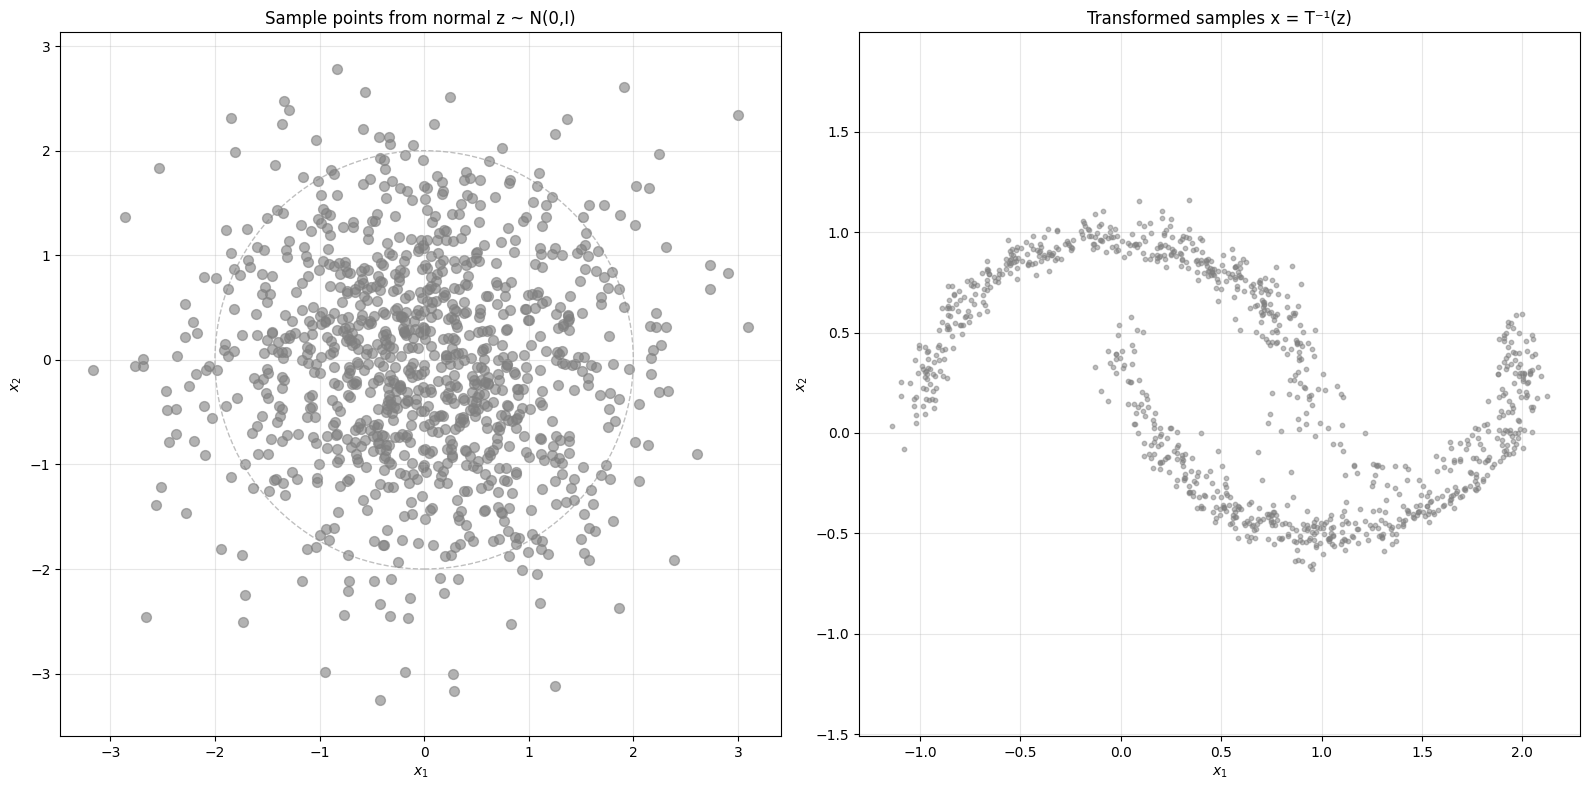

In [5]:
# Criar e treinar RealNVP em dados 2D
# RealNVP from zuko: 2 sample features, no context features
realnvp_2d = zuko.flows.RealNVP(
    features=2,
    transforms=4,
    hidden_features=[64, 64]
).to(device)

optimizer_rnvp_2d = optim.Adam(realnvp_2d.parameters(), lr=1e-3)

print("Treinando RealNVP em dados 2D...")
train_realnvp(
    realnvp_2d,
    dataloader_2d,
    optimizer_rnvp_2d,
    device,
    num_epochs=50
)

# Avaliar log-likelihood
realnvp_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    dist = realnvp_2d(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

plot_transformation_realnvp(
    realnvp_2d,
    n_samples=1000
)
plt.tight_layout()
plt.show()


## 2. MNIST Reduzido

In [6]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Criar e treinar CNF
vf_mnist = VectorField(features=100, hidden_dims=[128, 128], time_embed_dim=32)
cnf_mnist = CNF(vf_mnist).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-3)


Carregando MNIST reduzido...


### 2.1. CNF

In [7]:

print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, device, num_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")

plot_transformation(
    cnf_mnist,
    pca=dataset_mnist.pca,
    n_samples=100
)
plt.tight_layout()
plt.show()


Treinando CNF em MNIST reduzido...


Epoch 1/5:   2%|▏         | 9/469 [00:14<12:32,  1.64s/it]


KeyboardInterrupt: 

### 2.2. RealNVP

In [ ]:
# Criar e treinar RealNVP em MNIST reduzido
# RealNVP from zuko: 100 sample features, no context features
realnvp_mnist = zuko.flows.RealNVP(
    features=100,
    transforms=4,
    hidden_features=[128, 128]
).to(device)

optimizer_rnvp_mnist = optim.Adam(realnvp_mnist.parameters(), lr=1e-3)

print("Treinando RealNVP em MNIST reduzido...")
start_time = time.time()
train_realnvp(realnvp_mnist, dataloader_mnist, optimizer_rnvp_mnist, device, num_epochs=5)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
realnvp_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    dist = realnvp_mnist(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = realnvp_mnist(None).sample((1000,))
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")

plot_transformation(
    realnvp_mnist,
    pca=dataset_mnist.pca,
    n_samples=100
)
plt.tight_layout()
plt.show()


## 5. Análise de Escalabilidade

**Por que trace exato não escala para MNIST completo (784 dim)?**

- Custo computacional: O(d²) onde d é a dimensão
- Para d=784: precisamos de 784 backward passes
- Cada backward é O(784) → Total O(784²) = O(614,656)
- Isso é muito lento para treinamento prático!

**Solução:** Usar Hutchinson trace estimator (FFJORD) - O(d)
